In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from sklearn.preprocessing import RobustScaler, PowerTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif
import math
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [2]:
df = pd.read_csv(r"data\creditcard.csv")

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
print(df.shape)
print(df.columns)

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


Class
0    284315
1       492
Name: count, dtype: int64


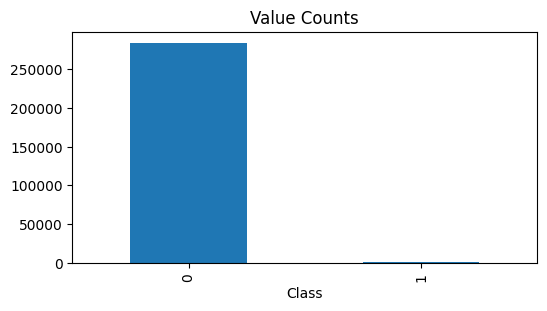

In [5]:
value_counts = df['Class'].value_counts()
print(value_counts)
value_counts.plot(kind="bar", figsize=(6, 3), title= "Value Counts")
plt.show()

### UNDERSTANDING THE DATA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
desc = df.describe().transpose()

In [8]:
def skew_check(row, tolerance= 0.10):
    rel_diff = (row['mean'] - row['50%']) / abs(row['50%'])
    if rel_diff > tolerance:
        skew_type = "Right-skewed"
    elif rel_diff < -tolerance:
        skew_type = "Left-skewed"
    else:
        skew_type = "Approximately Symmetric"
    return skew_type

In [9]:
desc['skewness'] = desc.apply(skew_check, axis=1)

C:\Users\ANSHU\AppData\Local\Temp\ipykernel_23460\188376232.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  rel_diff = (row['mean'] - row['50%']) / abs(row['50%'])


In [10]:
def outlier_check(row, factor=1.5):
    q1 = row['25%']
    q3 = row['75%']
    min_val = row['min']
    max_val = row['max']

    iqr = q3 - q1

    # Edge case: constant or near-constant column
    if iqr == 0:
        return "No Outliers (IQR = 0)"

    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr

    if min_val < lower_bound and max_val > upper_bound:
        return "Outliers on Both Sides"
    elif min_val < lower_bound:
        return "Lower-side Outliers"
    elif max_val > upper_bound:
        return "Upper-side Outliers"
    else:
        return "No Significant Outliers"


In [11]:
desc['outlier_status'] = desc.apply(outlier_check, axis=1)

In [12]:
# desc.head(10)

In [13]:
print("Total no of columns: ", df.shape[-1])
print("----"*10)
print("Skewnwss Check:\n", desc['skewness'].value_counts())
print("----"*10)
print("Outliers check:\n", desc['outlier_status'].value_counts())
print("----"*10)


Total no of columns:  31
----------------------------------------
Skewnwss Check:
 skewness
Right-skewed    16
Left-skewed     15
Name: count, dtype: int64
----------------------------------------
Outliers check:
 outlier_status
Outliers on Both Sides     27
No Significant Outliers     1
Lower-side Outliers         1
Upper-side Outliers         1
No Outliers (IQR = 0)       1
Name: count, dtype: int64
----------------------------------------


#### Data Preprocessing checks
    - No null records
    - No mixed datatypes
    - Approx all the columns have heavy tail effect (Extreme values are present)


In [14]:
# df.isna().sum()
# df.info()
results = []

for col in df.select_dtypes(include='number').columns:
    q = df[col].quantile([0.01, 0.25, 0.75, 0.99])
    iqr = q[0.75] - q[0.25]

    if iqr == 0:
        tail_ratio = None
    else:
        tail_ratio = (q[0.99] - q[0.01]) / iqr

    results.append({
        "column": col,
        "kurtosis": kurtosis(df[col], fisher=False, nan_policy='omit'),
        "tail_ratio": tail_ratio
    })

heavy_tail_df = pd.DataFrame(results)
heavy_tail_df["heavy_tail_flag"] = (
    (heavy_tail_df["kurtosis"] > 3) |
    (heavy_tail_df["tail_ratio"] > 10)
)


In [15]:
heavy_tail_df

,column,kurtosis,tail_ratio,heavy_tail_flag
0,Time,1.706472,1.975340,False
1,V1,35.486088,3.935720,True
2,V2,98.771404,6.248502,True
3,V3,29.619062,3.497575,True
4,V4,5.635388,4.630091,True
5,V5,209.900907,4.975207,True
6,V6,45.641724,5.419764,True
7,V7,408.600275,5.076915,True
8,V8,223.583080,11.399532,True
9,V9,6.731224,4.387921,True


In [16]:
def plot_graphs(cols):
    n = len(cols)

    plt.figure(figsize=(5*n, 3))  # width depends on number of plots

    for i, col in enumerate(cols, 1):
        plt.subplot(1, n, i)  # 1 row, n columns, position i
        sns.histplot(df[col], bins=50, kde=True, color="skyblue", edgecolor="black")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.title(f"Distribution of {col}")

    plt.tight_layout()
    plt.show()

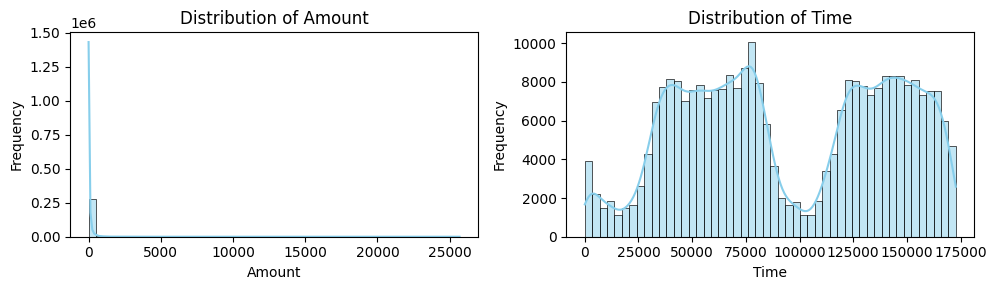

In [17]:
cols = ["Amount", "Time"]
plot_graphs(cols)

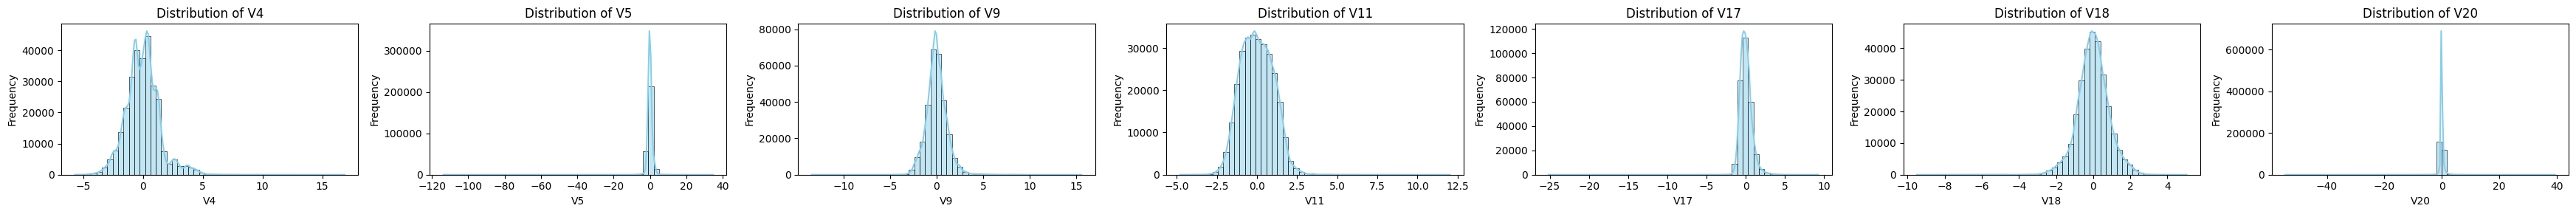

In [18]:
cols = ["V4", "V5", "V9","V11","V17", "V18", "V20"]
plot_graphs(cols)

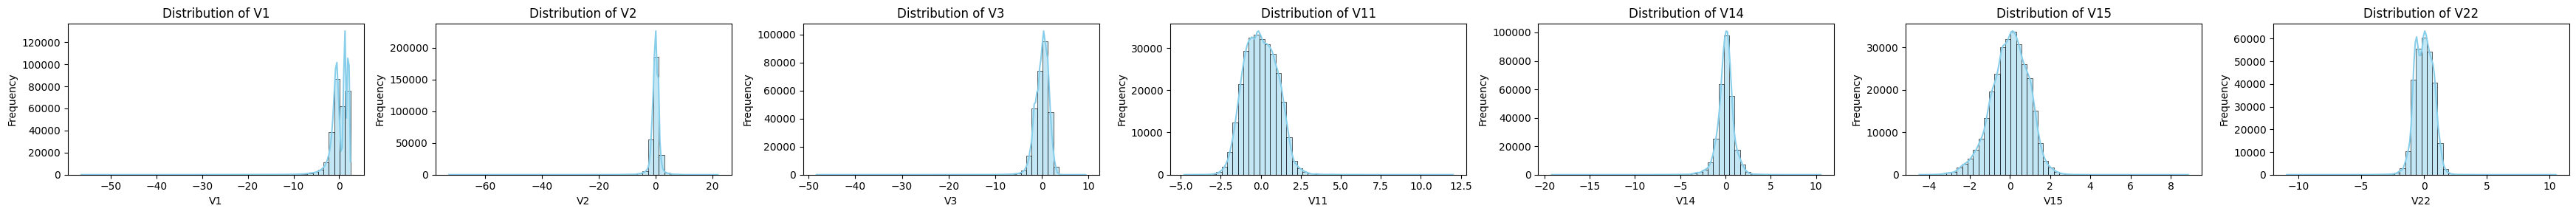

In [19]:
cols = ["V1", "V2", "V3","V11","V14", "V15", "V22"]
plot_graphs(cols)

In [20]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

### Tackling Outliers and Skewness

In [21]:
# Columns to exclude
exclude_cols = ['Class', 'Time']  # adjust as needed
numeric_cols = df.select_dtypes(include='number').columns
cols_to_transform = [col for col in numeric_cols if col not in exclude_cols]

# 1️⃣ Winsorization (cap extremes at 1st and 99th percentile)
for col in cols_to_transform:
    df[col] = df[col].clip(
        lower=df[col].quantile(0.01),
        upper=df[col].quantile(0.99)
    )

# 2️⃣ Apply PowerTransformer (Yeo-Johnson) for skew correction
pt = PowerTransformer(method='yeo-johnson', standardize=False)
df[cols_to_transform] = pt.fit_transform(df[cols_to_transform])

# 3️⃣ Apply RobustScaler to handle outliers and scale
scaler = RobustScaler()
df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])

# ✅ df now has skew-corrected, winsorized, and robustly scaled numeric features


In [22]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-0.480231,-0.097138,1.464519,0.804681,-0.222499,0.535517,0.179034,0.142541,0.329051,...,0.026888,0.253403,-0.326112,0.032786,0.169472,-0.249118,0.838132,-0.240951,0.734341,0
1,0.0,0.586003,0.144681,-0.007120,0.282788,0.087192,0.163652,-0.105516,0.116815,-0.166587,...,-0.487542,-0.601387,0.357496,-0.435580,0.228802,0.302536,-0.063361,0.026514,-0.764869,0
2,1.0,-0.479795,-0.915969,0.953244,0.242541,-0.355108,1.152449,0.684956,0.433715,-1.248458,...,0.644941,0.716216,2.652480,-0.779459,-0.498556,-0.156537,-0.344204,-0.518082,1.077615,0
3,1.0,-0.358000,-0.174604,0.966124,-0.556936,0.033744,0.929401,0.177237,0.700596,-1.135479,...,-0.192727,-0.001409,-0.595339,-1.199370,0.998107,-0.310835,0.382991,0.392988,0.662182,0
4,2.0,-0.418699,0.607820,0.808617,0.256265,-0.277608,0.298970,0.501369,-0.505950,0.676664,...,0.048241,0.741179,-0.416422,0.129076,-0.325931,0.877305,1.408092,1.736988,0.446407,0


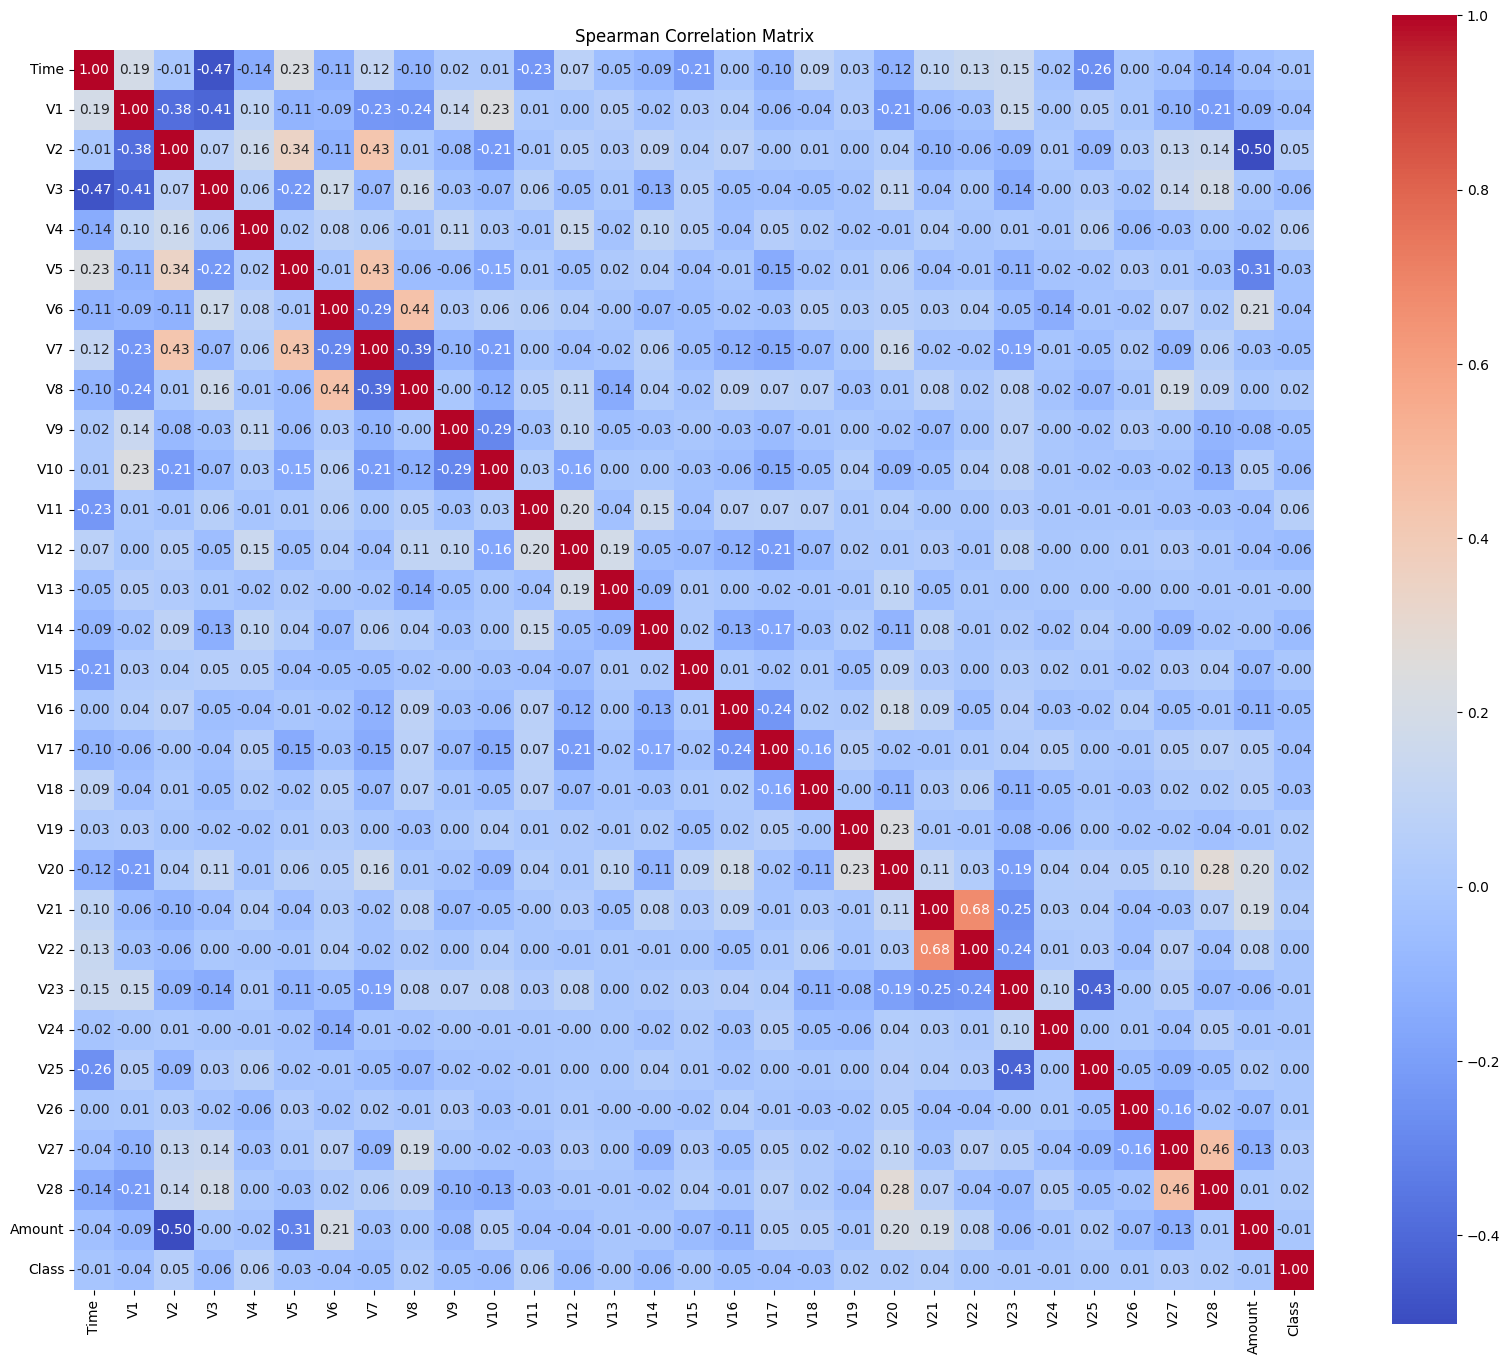

In [23]:
# Exclude non-numeric / target columns if needed
numeric_cols = df.select_dtypes(include='number').columns
corr_spearman = df[numeric_cols].corr(method='spearman')
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 17))
sns.heatmap(
    corr_spearman, 
    annot=True,        # show correlation values
    fmt=".2f",         # formatting
    cmap="coolwarm",   # color palette
    cbar=True,
    square=True
)
plt.title("Spearman Correlation Matrix")
plt.show()


In [24]:
# Select numeric features only (exclude target/time)
X = df[numeric_cols].drop(['Class', 'Time'], axis=1)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

Analysis: Correlation values are less than 0.50 and VIF values are in range of 1-2 → very low multicollinearity.

#### Feature-Target Relationship Analysis

In [25]:
# Select numeric features excluding target and time
exclude_cols = ['Class', 'Time']
numeric_cols = [col for col in df.select_dtypes(include='number').columns if col not in exclude_cols]

# Compute Mutual Information
mi = mutual_info_classif(df[numeric_cols], df['Class'], discrete_features=False, random_state=42)

# Create a DataFrame for ranking
mi_df = pd.DataFrame({'Feature': numeric_cols, 'Mutual_Information': mi})
mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False).reset_index(drop=True)

print(mi_df)


   Feature  Mutual_Information
0      V14            0.006234
1      V10            0.005806
2      V17            0.005583
3      V12            0.005402
4      V11            0.005002
5       V3            0.004465
6      V16            0.004366
7       V4            0.004090
8       V7            0.003602
9       V9            0.002908
10      V2            0.002873
11     V18            0.002729
12     V27            0.002270
13     V21            0.002220
14      V6            0.002092
15      V5            0.002003
16  Amount            0.001940
17      V1            0.001838
18     V28            0.001711
19      V8            0.001555
20     V19            0.001419
21     V20            0.001103
22     V23            0.000704
23     V24            0.000689
24     V26            0.000540
25     V25            0.000538
26     V13            0.000444
27     V15            0.000271
28     V22            0.000216


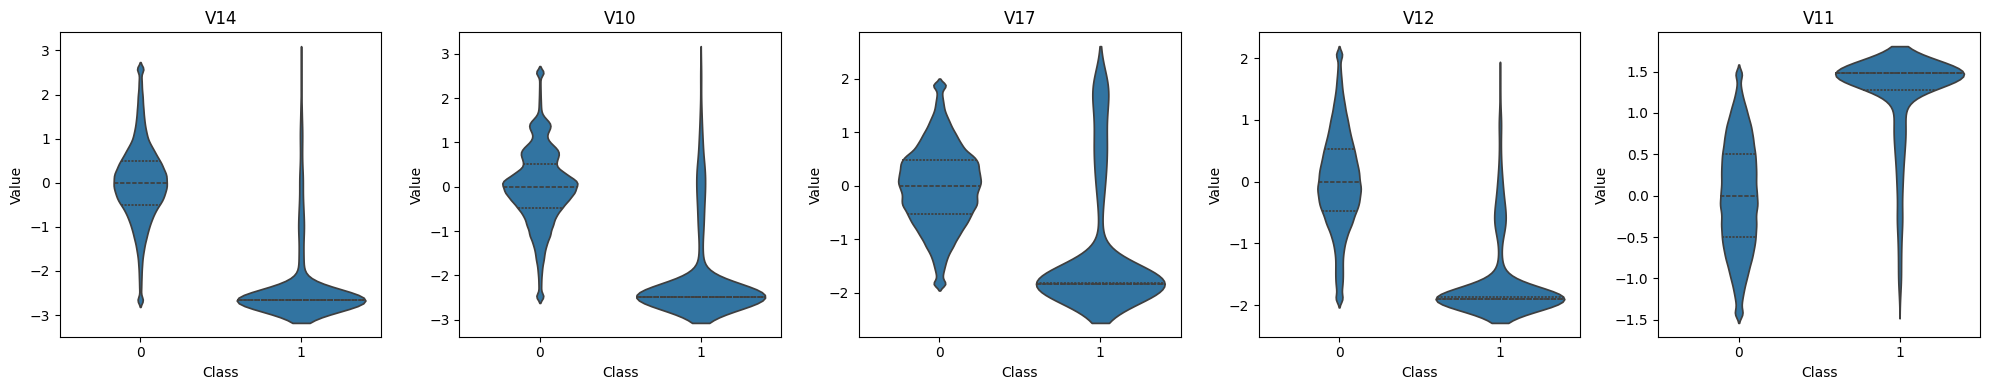

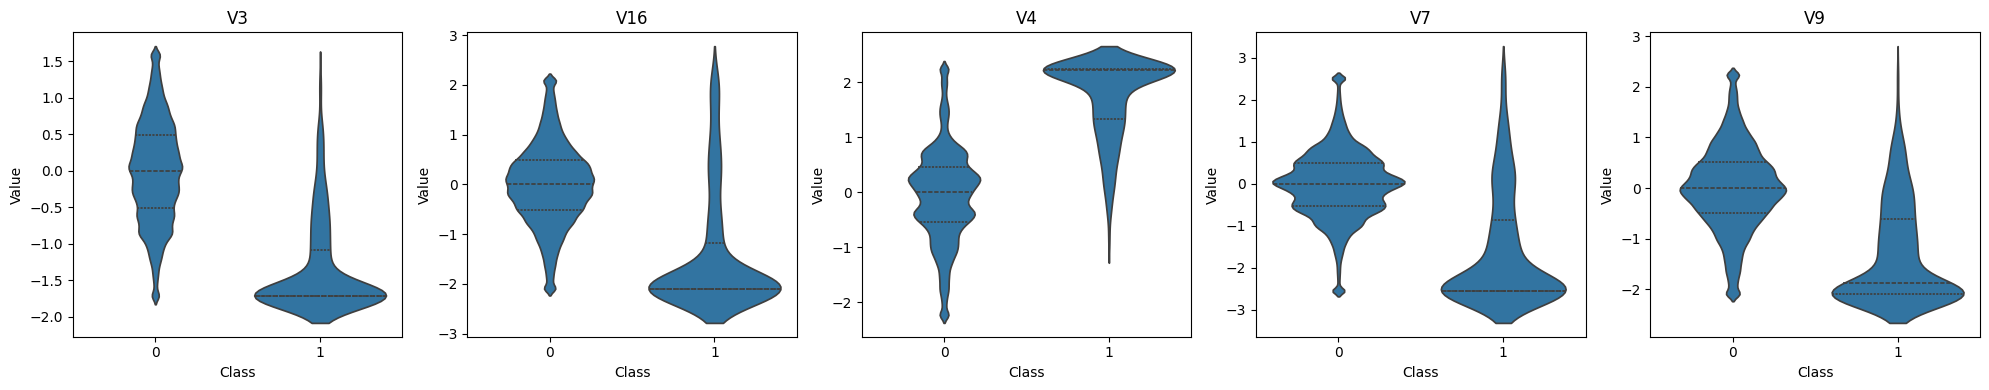

In [26]:
# Top features to plot (you can adjust number)
top_features = mi_df['Feature'][:10] # Or select top N: mi_df['Feature'][:20]

# Batch size
batch_size = 5
num_batches = math.ceil(len(top_features) / batch_size)

for i in range(num_batches):
    batch = top_features[i*batch_size:(i+1)*batch_size]
    fig, axes = plt.subplots(nrows=1, ncols=len(batch), figsize=(20, 4))
    
    if len(batch) == 1:
        axes = [axes]  # Ensure axes is iterable
    
    for ax, col in zip(axes, batch):
        sns.violinplot(x='Class', y=col, data=df, inner='quartile', ax=ax)
        ax.set_title(col)
        ax.set_xlabel('Class')
        ax.set_ylabel('Value')
        ax.tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()


## Commonly used techniques to handle highly imbalanced datasets

### 1. Data Level Techniques

#### A. Oversampling (increase minority class)
- **RANDOM OVERSAMPLING**
    - Duplicate minority class records randomly.
    - Pros: Simple, preserves all majority data
    - Cons: Overfitting risk due to duplicates
- **SMOTE (Synthetic Minority Over-sampling Technique)**
    - Creates synthetic minority samples by interpolating between neighbors.
    - Pros: Reduces overfitting vs random oversampling
    - Cons: Can create noisy / overlapping samples
- **ADASYN (Adaptive Synthetic Sampling)**
    - ariant of SMOTE, focuses more on minority samples that are harder to learn
- **Borderline-SMOTE**
    - Generates synthetic samples near the decision boundary only.

**RANDOM OVERSAMPLING**

In [27]:
X = df.drop(columns=['Class', 'Time'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, stratify=y, random_state=42)

In [28]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [29]:
y_train.value_counts(normalize=True) * 100
y_train_ros.value_counts(normalize=True) * 100


Class
0    50.0
1    50.0
Name: proportion, dtype: float64

#### Baseline Model1: Logistic Regression

In [30]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score, ConfusionMatrixDisplay, roc_curve

def train_evaluate_model(model,X_train,y_train,X_test,y_test,model_name="Model"):
    # Train
    model.fit(X_train, y_train)
    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    # Metrics
    print(f"\n{model_name}")
    print("-" * len(model_name))
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 4))
    print("PR-AUC :", round(average_precision_score(y_test, y_prob), 4))
    return {
        "model_name": model_name,
        "y_pred": y_pred,
        "y_prob": y_prob
    }

In [31]:
def train_evaluate_model_train(model,X_train,y_train,model_name="Model"):
    # Train
    model.fit(X_train, y_train)
    # Predictions
    y_pred = model.predict(X_train)
    y_prob = model.predict_proba(X_train)[:, 1]
    # Metrics
    print(f"\n{model_name}")
    print("-" * len(model_name))
    print(classification_report(y_train, y_pred))
    print("ROC-AUC:", round(roc_auc_score(y_train, y_prob), 4))
    print("PR-AUC :", round(average_precision_score(y_train, y_prob), 4))
    return {
        "model_name": model_name,
        "y_pred": y_pred,
        "y_prob": y_prob
    }

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

results = []
## Logistic Regression
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)
results.append(train_evaluate_model(log_reg,X_train_ros,y_train_ros,X_test,y_test,model_name="Logistic Regression (ROS)"))

## Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
results.append(train_evaluate_model(rf,X_train_ros,y_train_ros,X_test,y_test,model_name="Random Forest Classifier (ROS)"))



Logistic Regression (ROS)
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.91      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962

ROC-AUC: 0.9754
PR-AUC : 0.7243

Random Forest Classifier (ROS)
------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.77      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9675
PR-AUC : 0.8824


In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrices(results, y_test):
    n = len(results)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 3))

    if n == 1:
        axes = [axes]

    for ax, res in zip(axes, results):
        cm = confusion_matrix(y_test, res["y_pred"])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=ax, cmap="Blues", values_format="d")
        ax.set_title(res["model_name"])

    plt.tight_layout()
    plt.show()


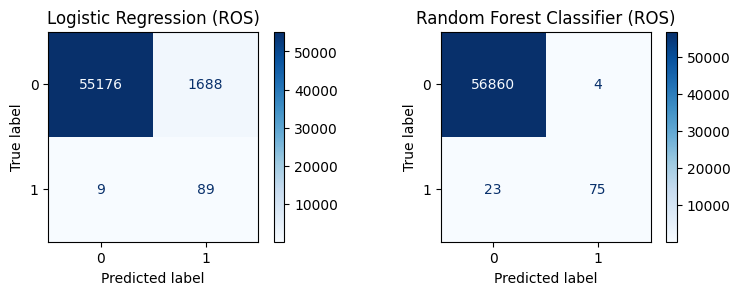

In [34]:
plot_confusion_matrices(results, y_test)

In [35]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(results, y_test):
    plt.figure(figsize=(6, 4))

    for res in results:
        fpr, tpr, _ = roc_curve(y_test, res["y_prob"])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{res["model_name"]} (AUC={roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

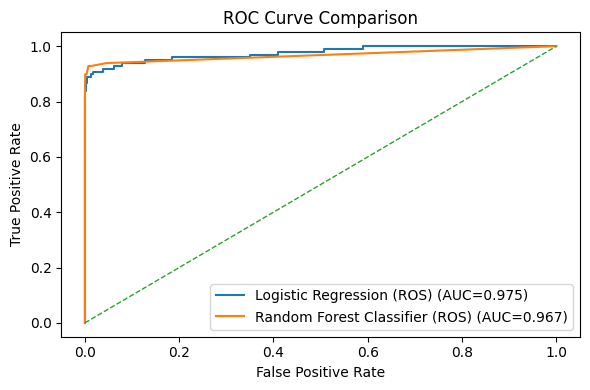

In [36]:
plot_roc_curves(results, y_test)

### Analysis:
- with **ROC ≈ 0.97** and **very different confusion matrices**, this is exactly the right time to check overfitting.
- Recall(Fraud) reduced to 0.77 in case of Random Forest → classic symptom of memorization / overfitting after oversampling.

### STEP1: COMPARE WITH TRAIN DATA

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

results = []
## Logistic Regression
log_reg_t = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)
results.append(train_evaluate_model_train(log_reg_t,X_train_ros,y_train_ros,model_name="Logistic Regression-train (ROS)"))

## Random Forest
rf_t = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
results.append(train_evaluate_model_train(rf_t,X_train_ros,y_train_ros,model_name="Random Forest Classifier-train (ROS)"))



Logistic Regression-train (ROS)
-------------------------------
              precision    recall  f1-score   support

           0       0.93      0.97      0.95    227451
           1       0.97      0.93      0.95    227451

    accuracy                           0.95    454902
   macro avg       0.95      0.95      0.95    454902
weighted avg       0.95      0.95      0.95    454902

ROC-AUC: 0.9891
PR-AUC : 0.9909

Random Forest Classifier-train (ROS)
------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902

ROC-AUC: 1.0
PR-AUC : 1.0


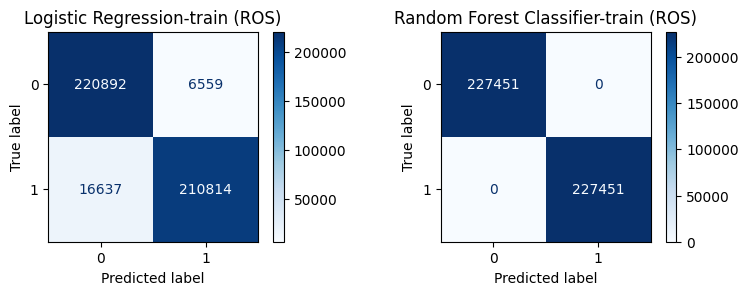

In [38]:
plot_confusion_matrices(results, y_train_ros)

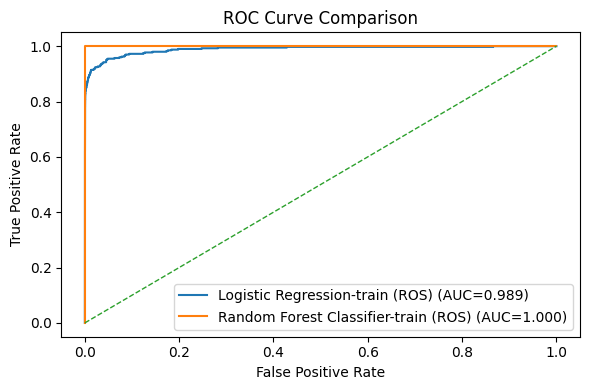

In [39]:
plot_roc_curves(results, y_train_ros)

### ANALYSIS:

Random Forest (ROS) – **SEVERE OVERFITTING ❌**
On **train (ROS)**:
* Confusion Matrix → **perfect classification** 
* ROC-AUC = **1.00**
* PR-AUC = **1.00**
* Precision / Recall / F1 = **1.00**
On **test** (earlier):
* Recall (fraud) ≈ **0.77**
* FN = **23**
* Performance drops sharply
**This is textbook memorization caused by oversampling + trees**.

Logistic Regression (ROS) – **NOT overfitting ✅**
On **train (ROS)**:
* ROC-AUC ≈ **0.989**
* PR-AUC ≈ **0.991**
* Errors still exist (not perfect)
On **test**:
* ROC-AUC ≈ **0.975**
* Very small generalization gap (**~0.014**)
This is **healthy generalization**.
---

**Anything > 0.02 for imbalanced problems is a red flag.**

Root cause
* Random Oversampling **duplicates minority samples**, 

Random Forest **memorizes duplicated points** and Trees split until **pure leaves** Result → perfect training, poor generalization

Logistic Regression: Linear decision boundary, Cannot memorize, Naturally regularized


### STEP2: Cross-validation on ORIGINAL imbalance

In [40]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_auc = cross_val_score(log_reg, X_train, y_train, scoring="roc_auc", cv=cv,n_jobs=-1)

print("Logistic Regression CV ROC-AUC scores:", cv_auc)
print("Logistic Regression Mean CV ROC-AUC:", cv_auc.mean())

cv_auc_rf = cross_val_score(rf, X_train, y_train, scoring="roc_auc", cv=cv,n_jobs=-1)

print("Random Forest CV ROC-AUC scores:", cv_auc_rf)
print("Random Forest Mean CV ROC-AUC:", cv_auc_rf.mean())

Logistic Regression CV ROC-AUC scores: [0.99356255 0.97903198 0.97340743 0.98939675 0.97533802]
Logistic Regression Mean CV ROC-AUC: 0.9821473442434089
Random Forest CV ROC-AUC scores: [0.97246807 0.94683294 0.93403614 0.97267434 0.94675363]
Random Forest Mean CV ROC-AUC: 0.9545530229147282


### Step 3 — Learning curves (visual proof)

In [41]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(log_reg, X_train, y_train,scoring="roc_auc",cv=5,n_jobs=-1,train_sizes=np.linspace(0.1, 1.0, 5))

print("LR Train AUC:", train_scores.mean(axis=1))
print("LR Val   AUC:", val_scores.mean(axis=1))


LR Train AUC: [0.99731504 0.99372039 0.98853255 0.9888257  0.98970368]
LR Val   AUC: [0.95929589 0.96779592 0.97408793 0.97885822 0.98224874]


### SMOTE(Synthetic Minority Over-Sampling Techniques)

In [42]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(
    sampling_strategy=0.25,   # start conservative (10%)
    random_state=42,
    k_neighbors=5
)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print("Before SMOTE:", y_train.value_counts(normalize=True))
print("After  SMOTE:", y_train_sm.value_counts(normalize=True))

Before SMOTE: Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
After  SMOTE: Class
0    0.800002
1    0.199998
Name: proportion, dtype: float64


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

results = []
## Logistic Regression
log_reg_sm = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)
results.append(train_evaluate_model(log_reg_sm,X_train_sm,y_train_sm,X_test,y_test,model_name="Logistic Regression (SMOTE)"))

## Random Forest
rf_sm = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
results.append(train_evaluate_model(rf_sm,X_train_sm,y_train_sm,X_test,y_test,model_name="Random Forest Classifier (SMOTE)"))



Logistic Regression (SMOTE)
---------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.91      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962

ROC-AUC: 0.9745
PR-AUC : 0.7114

Random Forest Classifier (SMOTE)
--------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.83      0.86        98

    accuracy                           1.00     56962
   macro avg       0.95      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9714
PR-AUC : 0.8725


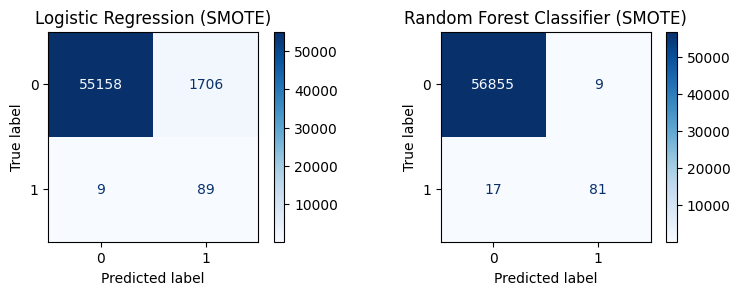

In [44]:
plot_confusion_matrices(results, y_test)

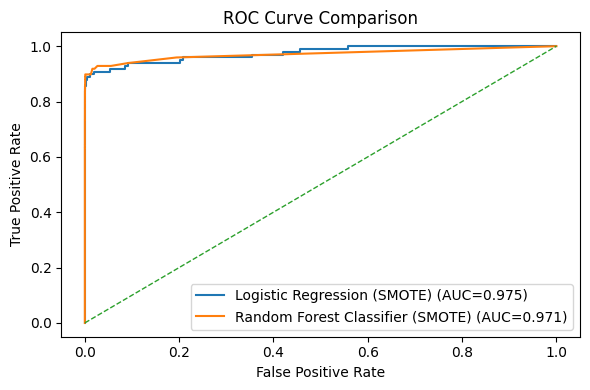

In [45]:
plot_roc_curves(results, y_test)

In [46]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(
    sampling_strategy=0.25,
    random_state=42
)

X_train_st, y_train_st = smote_tomek.fit_resample(X_train, y_train)


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

results = []
## Logistic Regression
log_reg_st = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)
results.append(train_evaluate_model(log_reg_st,X_train_st,y_train_st,X_test,y_test,model_name="Logistic Regression (SMOTE)"))

## Random Forest
rf_st = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
results.append(train_evaluate_model(rf_st,X_train_st,y_train_st,X_test,y_test,model_name="Random Forest Classifier (SMOTE)"))



Logistic Regression (SMOTE)
---------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.91      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962

ROC-AUC: 0.9745
PR-AUC : 0.7114

Random Forest Classifier (SMOTE)
--------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.83      0.86        98

    accuracy                           1.00     56962
   macro avg       0.95      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9714
PR-AUC : 0.8725


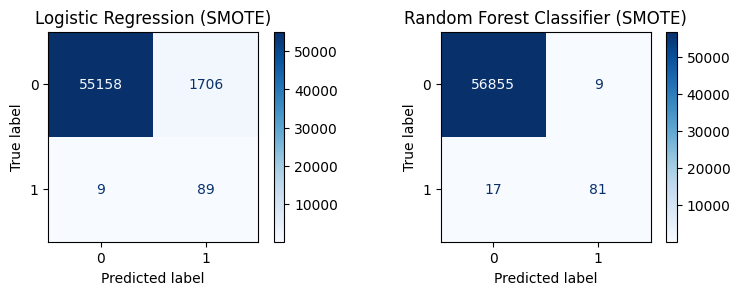

In [48]:
plot_confusion_matrices(results, y_test)

# Conclusion: 
- Oversampling is NOT appropriate for your dataset.We can stop here with full confidence.
- Undersampling is not good, because we will lose lot of data


In [49]:
rf1 = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=200,
    min_samples_split=500,
    max_features=0.5,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)

log_reg_base = LogisticRegression(
    penalty="l2",                 # safest, stable for high-dim data
    C=0.3,                        # stronger regularization (default = 1.0)
    solver="lbfgs",               # best for L2 + probability stability
    class_weight="balanced",      # handles extreme imbalance
    max_iter=2000,                # ensure convergence
    tol=1e-4,                     # stricter convergence
    fit_intercept=True,
    warm_start=False,
    n_jobs=-1,
    random_state=42
)

In [50]:
result = []
result.append(train_evaluate_model(log_reg_base,X_train,y_train,X_test,y_test,model_name="Logistic Regression (No Oversampling)"))

result.append(train_evaluate_model(rf1,X_train,y_train,X_test,y_test,model_name="RF Classifier (No Oversampling)"))


Logistic Regression (No Oversampling)
-------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.91      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962

ROC-AUC: 0.9754
PR-AUC : 0.7249

RF Classifier (No Oversampling)
-------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.29      0.89      0.44        98

    accuracy                           1.00     56962
   macro avg       0.64      0.94      0.72     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9782
PR-AUC : 0.7052


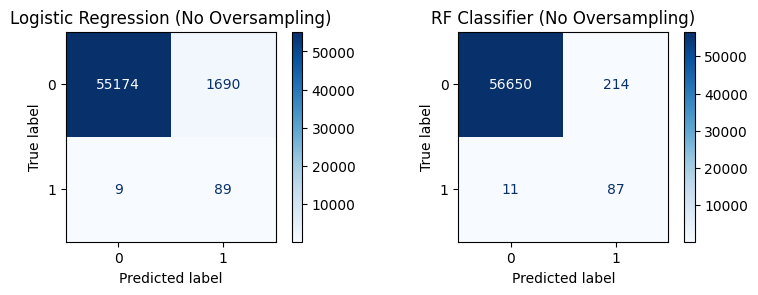

In [51]:
plot_confusion_matrices(result, y_test)

# 2nd Approach: Cost-sensitive learning

Instead of balancing classes artificially, we tell the model:

    - “Missing a fraud (FN) is much worse than falsely flagging a transaction (FP)”

This is done by assigning higher cost to class = 1.

So here, we first define the cost ratio

In [96]:
cost_ratio = 10
log_reg_cost = LogisticRegression(
    penalty="l2",
    C=0.3,
    solver="lbfgs",
    class_weight={0: 1, 1: cost_ratio},
    max_iter=2000,
    n_jobs=-1,
    random_state=42
)


In [97]:
a = train_evaluate_model(log_reg_cost,X_train,y_train,X_test,y_test,model_name=f"Logistic Regression (Cost Sensitivity: Cost Ratio = {cost_ratio})")


Logistic Regression (Cost Sensitivity: Cost Ratio = 10)
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.64      0.84      0.72        98

    accuracy                           1.00     56962
   macro avg       0.82      0.92      0.86     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9713
PR-AUC : 0.772


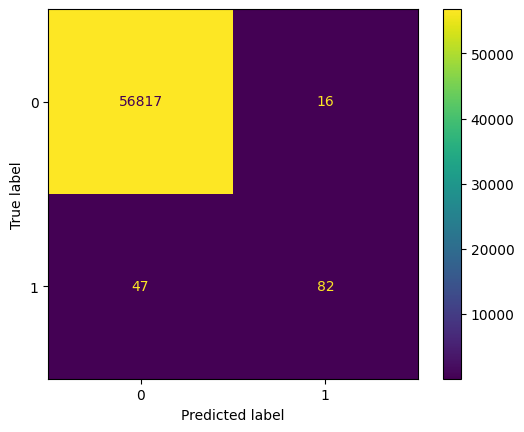

In [98]:
cm = confusion_matrix(a['y_pred'],y_test )
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

ANALYSIS
1. Recall dropped (.908 -> .84)
2. Precision values improved a lot. (It is better in avoiding False alarms)
3. F1 score improved from 0.09 to 0.72
4. But False Negative increased a lot. 

Let's try for Threshold tuning

In [99]:
from sklearn.model_selection import train_test_split

# First split: train + temp (val+test)
X_train2, X_temp, y_train2, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# Second split: validation + test
X_val, X_test2, y_val, y_test2 = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)


In [100]:
log_reg_cost.fit(X_train2, y_train2)

LogisticRegression(C=0.3, class_weight={0: 1, 1: 10}, max_iter=2000, n_jobs=-1,
                   random_state=42)

In [101]:
y_prob = log_reg_cost.predict_proba(X_val)[:, 1]

In [102]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.0, 1.01, 0.05)

metrics = []
for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    metrics.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred)
    })


c:\Users\ANSHU\DataScience\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [103]:
df2 = pd.DataFrame(metrics)

In [104]:
df2

,threshold,precision,recall,f1
0,0.00,0.001720,1.000000,0.003435
1,0.05,0.140171,0.836735,0.240117
2,0.10,0.253086,0.836735,0.388626
3,0.15,0.334728,0.816327,0.474777
4,0.20,0.404040,0.816327,0.540541
5,0.25,0.456647,0.806122,0.583026
6,0.30,0.509804,0.795918,0.621514
7,0.35,0.553191,0.795918,0.652720
8,0.40,0.565217,0.795918,0.661017
9,0.45,0.586466,0.795918,0.675325


In [ ]:
best = max(metrics, key=lambda x: x["f1"])
best["threshold"] 
##“I will predict Class = 1 (fraud) only if the model is at least 85% confident.”


0.8500000000000001

In [106]:
y_prob = log_reg_cost.predict_proba(X_test)[:, 1]  # probability of class 1
threshold = 0.85
y_pred = (y_prob >= threshold).astype(int)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[56842    22]
 [   18    80]]


In [108]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.78      0.82      0.80        98

    accuracy                           1.00     56962
   macro avg       0.89      0.91      0.90     56962
weighted avg       1.00      1.00      1.00     56962



What does **threshold = 0.85** mean?

Logistic Regression model outputs **probabilities**, not class labels. This give values like: 0.02, 0.15, 0.63, 0.91, 0.87, etc. Now, threshold is the decison cutoff with threshold = 0.85, we are saying "I will predict Class = 1 (fraud) only if the model is at least 85% confident."

Why threshold tuning matters (especially for imbalance)

Our dataset:
* Fraud = **0.17%**
* Non-fraud = **99.83%**

A 0.5 threshold is **not optimal** for such imbalance because: 

* The model may assign 0.6–0.8 probabilities to many borderline cases
* That causes unnecessary false positives(Many false alarms)

By raising the threshold to **0.85**, we:

* Filter out weak fraud signals
* Keep only **high-confidence fraud predictions**

## Explanation- SHAP

In [111]:
# pip install shap

In [112]:
import shap

c:\Users\ANSHU\DataScience\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [115]:
explainer = shap.LinearExplainer(
    log_reg_cost,
    X_train,
    feature_perturbation="interventional"
)

shap_values = explainer.shap_values(X_test)

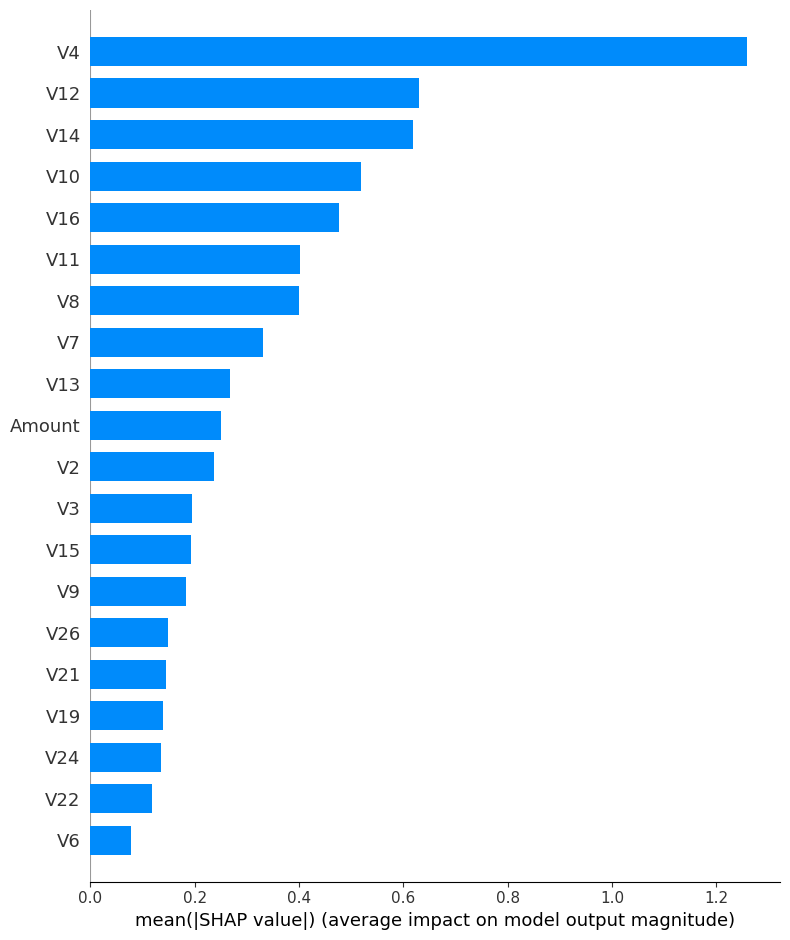

In [119]:
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar"
)


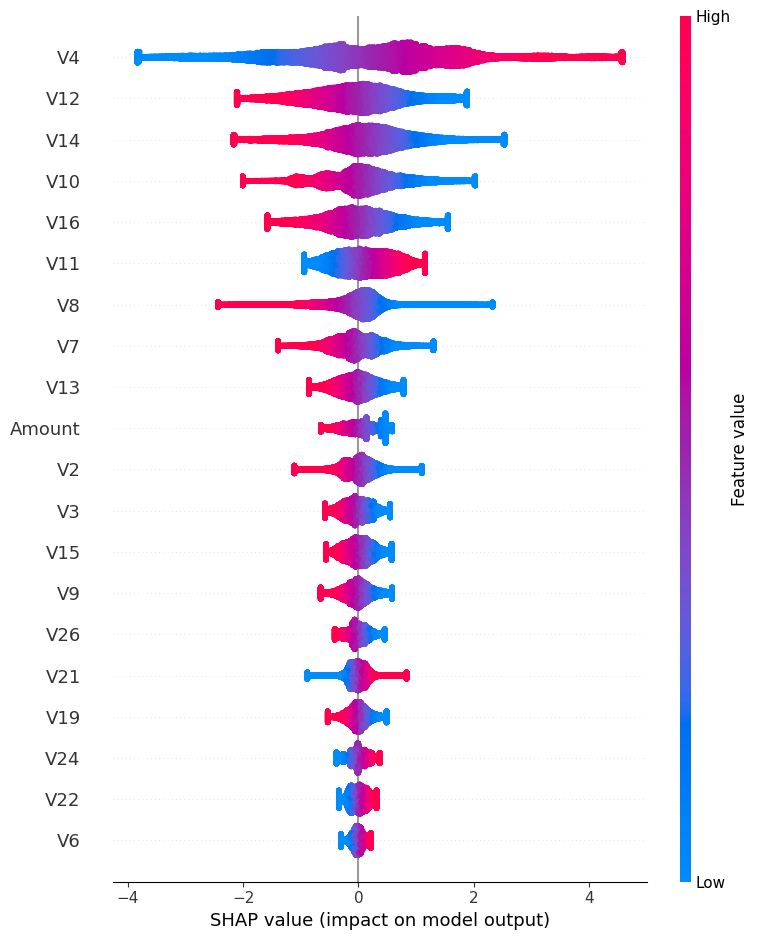

In [120]:
shap.summary_plot(
    shap_values,
    X_test
)


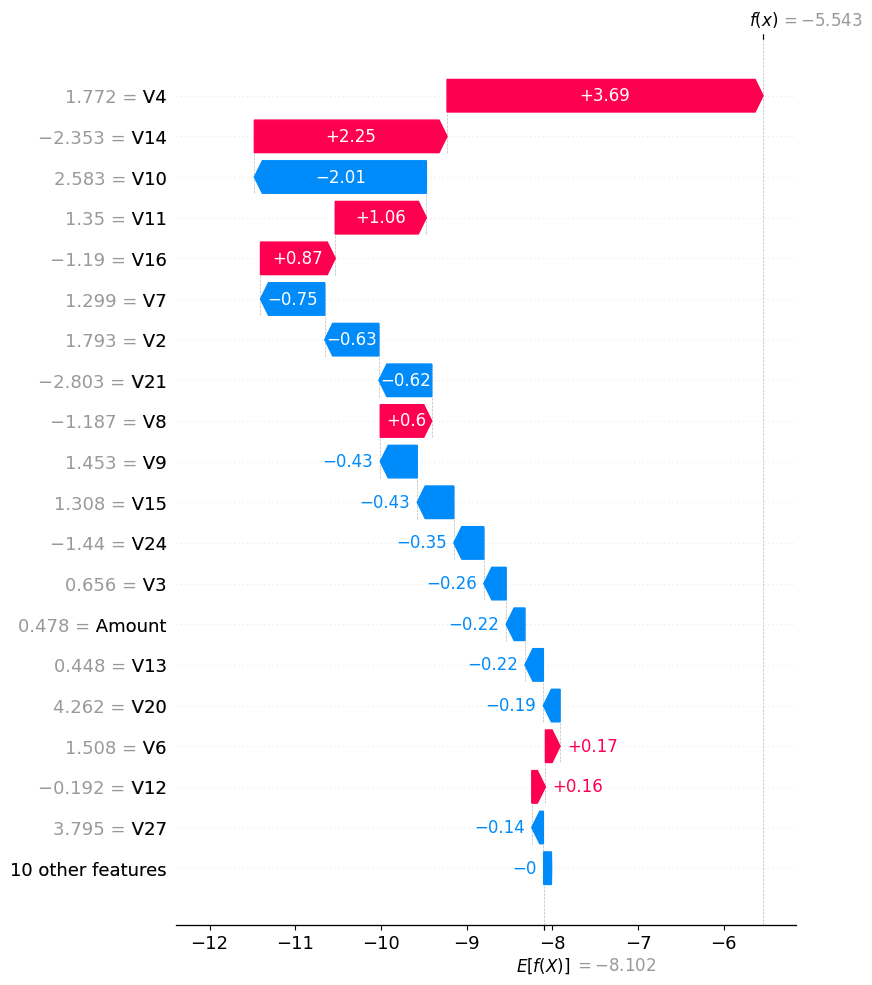

In [129]:
idx = X_test.index[2]

shap_exp = shap.Explanation(
    values=shap_values[X_test.index.get_loc(idx)],
    base_values=explainer.expected_value,
    data=X_test.loc[idx],
    feature_names=X_test.columns
)

plt.figure(figsize=(4, 8))
shap.plots.waterfall(shap_exp, max_display=20)
plt.show()